# 두 마리의 토끼 잡기<br>
하나의 인공신경망으로 MNIST와 우리가 그린 그림을 모두 잘 예측하도록 만들어봅시다.<br>
자료실의 Pics.zip 파일을 Colab에 업로드한 후 다음을 진행합니다.<br>
Pics.zip은 여러분이 그린 그림들을 모아둔 압축파일입니다.

In [7]:
import os

# 디렉토리 만들기: our_mnist/0, our_mnist/1, ..., our_mnist/9
# 0에는 0에 해당하는 그림들이, ..., 9에는 9에 해당하는 그림들이 저장됩니다.
os.mkdir('our_mnist')
for i in range(10):
  os.mkdir(f'our_mnist/{i}')

In [8]:
# Pics.zip 압축풀고 지우기
!unzip Pics.zip
!rm Pics.zip

Archive:  Pics.zip
  inflating: 2020200054UA_╣о╜┬╟Ў_╝¤└┌.zip  
  inflating: 2015722043UA_└╠╜┬└ч_mnist.zip  
  inflating: 2016726045UA_╛╚┴╪╕Ё_╝¤└┌.zip  
  inflating: 2016726065UA_┴╓╗є╣╬_deepLearning.zip  
  inflating: 2016726070UA_╣┌└п┴°_2016726070_pics.zip  
  inflating: 2016726072UA_┴╢╟Ў╣╬_dataset.zip  
  inflating: 2017203001UA_┴д└п╝╖_2017203001┴д└п╝╖_╝¤└┌ └╠╣╠┴Ў.zip  
  inflating: 2017203011UA_╚л╕э┴╪_img.zip  
  inflating: 2017203043UA_├╓└╬┐ь_╝¤└┌.zip  
  inflating: 2017203050UA_╟у╝о┴°_╝¤└┌_╟у╝о┴°.zip  
  inflating: 2017203066UA_╝█╡╡╚╞_KW_MNIST.zip  
  inflating: 2017742014UA_▒ш▒д╟Ў_▒ш▒д╟Ў.zip  
  inflating: 2018203070UA_└х└п├в_2018203070└х└п├в.zip  
  inflating: 2019603019UA_▒ш╝Ў░т_╝¤└┌.zip  
  inflating: 2018803003UA_┐░└ч░ц.zip  


In [9]:
from pathlib import Path
import zipfile

# 현재 디렉토리의 모든 파일 검사
for filename in os.listdir('.'):
  # zip 파일에 대해
  if filename.endswith('.zip'):
    # 학번 저장
    prefix = filename[:9]

    # zip 열기
    zipdata = zipfile.ZipFile(filename)
    zipinfos = zipdata.infolist()

    # 압축된 파일 하나씩 검사하기
    for zipinfo in zipinfos:
      if zipinfo.filename.endswith('.png'):
        # 경로 제외하기
        zippedFilename = Path(zipinfo.filename).stem + '.png'
        # 숫자 인식
        digit = zippedFilename[0]
        # 학번_ 붙이기
        zipinfo.filename = prefix + '_' + zippedFilename
        # 압축 풀기
        zipdata.extract(zipinfo, f'our_mnist/{digit}')

## 우리 그림 무작위로 그려보기
our_mnist 하위 디렉토리 (0, 1, ..., 9)에서 무작위로 하나씩 그려봅시다.

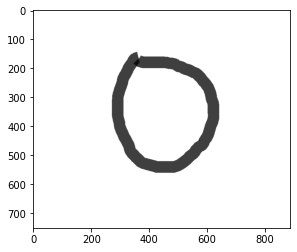

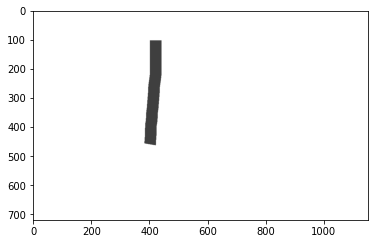

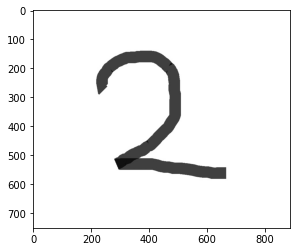

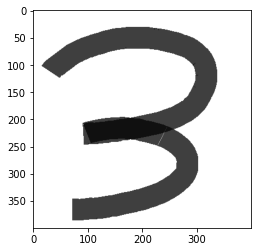

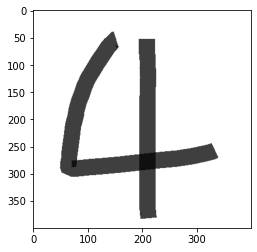

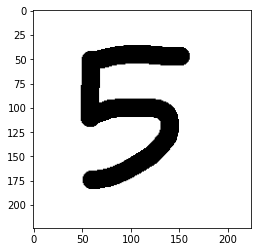

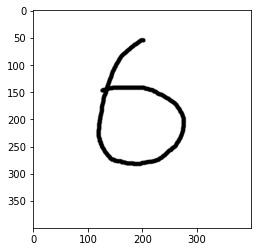

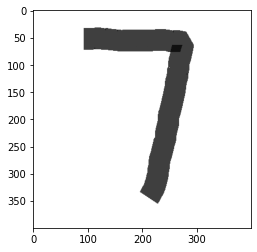

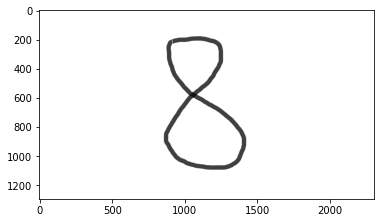

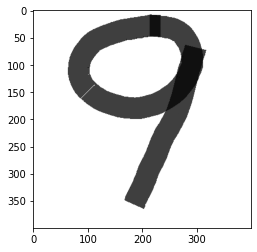

In [ ]:
# PNG 파일을 그립니다.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

for i in range(10):
  rand_file = random.choice(os.listdir(f'our_mnist/{i}/'))
  img = mpimg.imread(f'our_mnist/{i}/' + rand_file)
  imgplot = plt.imshow(img)
  plt.show()

##TODO1: image_prepare (784,)가 아닌 (28, 28, 1)을 return하도록 변경<br>
Hint: 가장 마지막에 NumPy를 이용하여 list를 배열로 변환하고 reshape하여 반환

In [10]:
# image_prepare(파일이름)으로 호출하면 정규화된 일차원 리스트를 반환합니다.

import numpy as np
from PIL import Image, ImageFilter

def image_prepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]

    # 수정할 곳 
    return np.array(tva).reshape(28,28,1)


## 우리가 그린 그림으로 훈련/테스트 데이터셋 만들기
2018 미만 학번: 훈련 / 2018 이상 학번: 테스트

In [11]:
from PIL import Image

our_train_images = []
our_train_labels = []

our_test_images = []
our_test_labels = []

for i in range(10):
  for filename in os.listdir(f'our_mnist/{i}/'):    
    if filename < '2018':
      our_train_images.append(image_prepare(f'our_mnist/{i}/' + filename))
      our_train_labels.append(i)  
    else:
      our_test_images.append(image_prepare(f'our_mnist/{i}/' + filename))
      our_test_labels.append(i)  

our_train_images = np.asarray(our_train_images)
our_train_labels = np.asarray(our_train_labels)
our_test_images = np.asarray(our_test_images)
our_test_labels = np.asarray(our_test_labels)

In [172]:
our_train_images.shape

(100, 28, 28, 1)

In [173]:
our_train_labels.shape

(100,)

## 훈련 데이터에서 무작위로 9장 그려보기

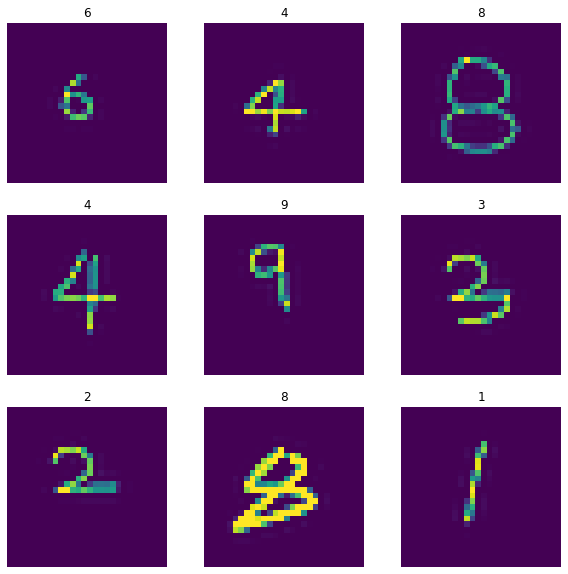

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  rand = random.randint(0, len(our_train_images) - 1)
  plt.imshow(our_train_images[rand].reshape(28, 28))
  plt.title(our_train_labels[rand])
  plt.axis("off")

## TODO2: 테스트 데이터에서 랜덤하게 9장 그려보기<br>
컴퓨터가 예측하기 쉬울까요?

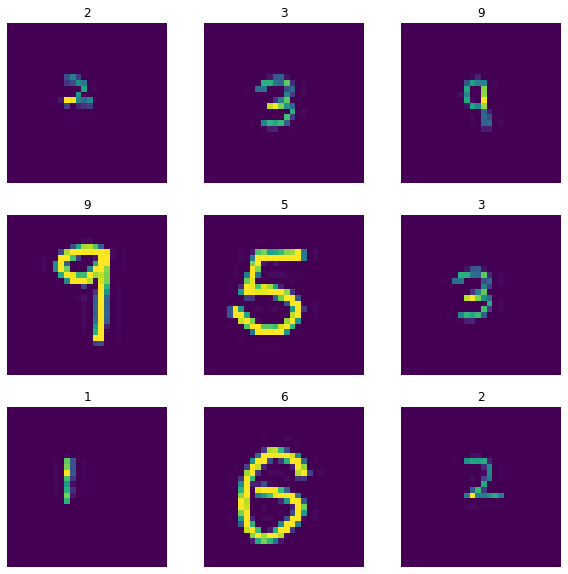

In [ ]:
# 그려보세요.
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  rand = random.randint(0, len(our_test_images) - 1)
  plt.imshow(our_test_images[rand].reshape(28, 28))
  plt.title(our_test_labels[rand])
  plt.axis("off")

## MNIST 불러와서 [0, 1]로 정규화하기

In [12]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

11501568/11490434 [==============================] - 0s 0us/step


In [175]:
train_images.shape

(60000, 28, 28)

In [176]:
test_images.shape

(10000, 28, 28)

## TODO3: MNIST 훈련 데이터에서 무작위로 9장 그려보기<br>
우리가 그린 그림과 비교해보세요.

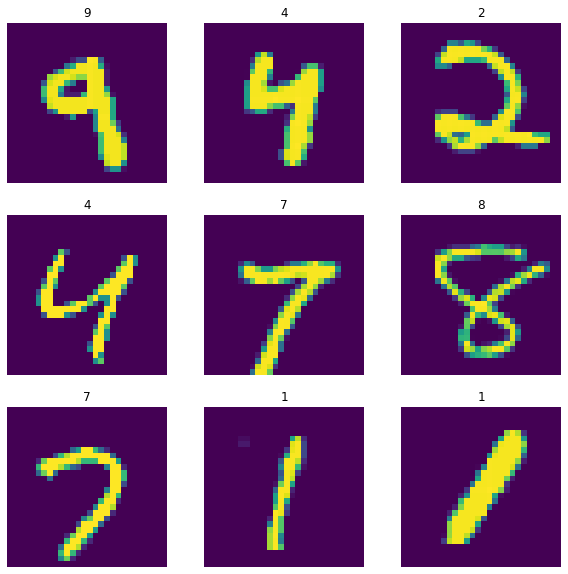

In [ ]:
# 그려보세요.
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  rand = random.randint(0, len(train_images) - 1)
  plt.imshow(train_images[rand].reshape(28, 28))
  plt.title(train_labels[rand])
  plt.axis("off")

## TODO4: 모델 만들어 훈련하기<br>
자유롭게 하나의 모델을 만들어 MNIST 테스트 데이터셋과 우리 테스트 데이터셋에서 90% 이상의 정확도를 달성해보세요.<br>
주의: 절대로 테스트 데이터 혹은 테스트 데이터를 가공한 데이터셋으로 훈련하면 안됩니다.<br>
**실수하기 굉장히 쉬우니 조심하세요.**

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(   
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

In [178]:
datagen.random_transform(our_train_images[0]).shape

(28, 28, 1)

In [14]:
tmp1 = []
tmp2 = []
for i in range(500):
  for j in range(100):
    tmp1.append(datagen.random_transform(our_train_images[j]))
    tmp2.append(our_train_labels[j])
    # np.concatenate((our_train_images, tmp), axis=None)
    # np.concatenate((our_train_labels, our_train_labels[j]), axis=None)
    # our_train_labels = our_train_labels + our_train_labels[j]


In [15]:
new_train_images = np.array(tmp1)
new_train_labels = np.array(tmp2)

mnist_train_images = np.array(train_images)
mnist_train_labels = np.array(train_labels)

In [16]:
new_train_images = np.concatenate((our_train_images, new_train_images))
new_train_labels = np.concatenate((our_train_labels, new_train_labels))

In [17]:
from tensorflow.keras.utils import to_categorical
mnist_train_images = np.expand_dims(mnist_train_images, -1)
mnist_train_labels = to_categorical(mnist_train_labels)

In [18]:
from tensorflow.keras.utils import to_categorical

new_train_labels = to_categorical(new_train_labels)

In [19]:
new_train_images = np.concatenate((new_train_images, mnist_train_images))
new_train_labels = np.concatenate((new_train_labels, mnist_train_labels))

In [20]:
# 모델을 자유롭게 만들어 보세요. (여러 개의 셀 사용 가능)
from keras import models
from keras import layers
import tensorflow as tf

model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu"))    
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation="relu"))    
model.add(layers.Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                  

In [22]:
epochs = 2
batch_size = 64

model.fit(new_train_images, new_train_labels , batch_size=batch_size, epochs=epochs)

Epoch 1/2
1721/1721 [==============================] - 775s 450ms/step - loss: 0.0387 - accuracy: 0.9891
Epoch 2/2
1721/1721 [==============================] - 776s 451ms/step - loss: 0.0218 - accuracy: 0.9935


In [24]:
from tensorflow.keras.utils import to_categorical
test_images = np.expand_dims(test_images, -1)
test_labels = to_categorical(test_labels)

In [25]:
# 아래와 동일한 모델로 정확도 90% 이상 달성
model.evaluate(test_images, test_labels)

313/313 [==============================] - 21s 65ms/step - loss: 0.0295 - accuracy: 0.9906


[0.029458124190568924, 0.9905999898910522]

In [26]:
from tensorflow.keras.utils import to_categorical
#our_test_images = np.expand_dims(our_test_images, -1)
our_test_labels = to_categorical(our_test_labels)

In [27]:
# 위와 동일한 모델로 정확도 90% 이상 달성
model.evaluate(np.asarray(our_test_images), np.asarray(our_test_labels))

2/2 [==============================] - 0s 26ms/step - loss: 0.4425 - accuracy: 0.9000


[0.4424680173397064, 0.8999999761581421]